In [1]:
import os
import numpy as np
import cv2
import argparse
import random
import gradio as gr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pickle
from skimage.feature import hog
import matplotlib.pyplot as plt
import pandas as pd
import io
import pandas as pd

In [ ]:
train_name_file_df = pd.read_csv("utils/train_df.csv")

list_dir = os.listdir("utils/combined_faces/")

N = 6480
orientations = 5
pixels_per_cell = (16, 16)
cells_per_block = (4, 4)

list_features = []

progress_counter = 0

list_features = np.zeros((1, N+2), dtype='float32')
list_file_name = []

for index, row in train_name_file_df.iterrows():
    
    # if progress_counter <= 10000:
    #     continue
    
    file_name = row['filename']
    age = row['age']
    target = row['target']
    
    img = cv2.imread("utils/combined_faces/"+file_name)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    feature_hog = hog(img_gray, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, block_norm='L2', visualize=False, transform_sqrt=True)
    img_features = np.append(feature_hog, [age, target])
    img_features = img_features.reshape(1, img_features.shape[0])
    list_features = np.append(list_features, img_features, axis=0)
    list_file_name.append(file_name)
    

    progress_counter += 1
    if progress_counter % 1000 == 0:
        print(f"Images processed for features extraction: {progress_counter}")
        
        
list_features = list_features[1:]


# with open("utils/HOG/hog_features_age_train.npy", "wb") as f:
#     np.save(f, list_features, allow_pickle=True)


feature_names = []
section = 1
    
for y in range(0, 6480):
    feature_names.append(f"sec{section}")
    section += 1

# feature_names.append('filename')
feature_names.append('age')
feature_names.append('target')

# create a dataframe with the features
train_df = pd.DataFrame(list_features, columns=feature_names)
train_df = pd.concat([train_df, train_name_file_df['filename']], axis=1)

train_df.to_csv("utils/HOG/train_df.csv", index=False)

In [2]:
train_df = pd.read_csv("utils/HOG/train_df.csv")
train_df

,sec1,sec2,sec3,sec4,sec5,sec6,sec7,sec8,sec9,sec10,...,sec6474,sec6475,sec6476,sec6477,sec6478,sec6479,sec6480,age,target,filename
0,0.423507,0.018889,0.012394,0.009579,0.100163,0.150292,0.023945,0.001845,0.005284,0.026846,...,0.411198,0.240025,0.005183,0.005829,0.163891,0.032640,0.002412,38.0,2.0,38_136.jpg
1,0.002415,0.000244,0.006556,0.000244,0.000000,0.015198,0.001465,0.003106,0.000976,0.000000,...,0.005675,0.003905,0.019317,0.022447,0.007020,0.002762,0.000298,1.0,1.0,1_195.jpg
2,0.033558,0.056283,0.017254,0.000154,0.002615,0.013257,0.044397,0.004264,0.000088,0.000140,...,0.482713,0.142037,0.013227,0.005120,0.005032,0.006044,0.005839,21.0,2.0,21_469.jpg
3,0.085965,0.032220,0.071718,0.103594,0.138163,0.145130,0.074026,0.094690,0.117337,0.104484,...,0.121752,0.009510,0.127481,0.071217,0.124961,0.021395,0.011218,26.0,2.0,26_1649.jpg
4,0.014213,0.016784,0.010332,0.010480,0.012398,0.150060,0.043606,0.028280,0.056114,0.173562,...,0.008028,0.014250,0.019762,0.017716,0.009774,0.018017,0.030261,54.0,3.0,54_419.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23435,0.038818,0.021195,0.027264,0.057173,0.164173,0.312733,0.041423,0.001972,0.002578,0.003018,...,0.005133,0.014200,0.225668,0.003702,0.016907,0.060721,0.106805,5.0,1.0,5_358.jpg
23436,0.132144,0.042062,0.021850,0.012542,0.053584,0.090470,0.029809,0.056685,0.081959,0.063967,...,0.010052,0.045535,0.030437,0.001922,0.000168,0.001564,0.001286,10.0,1.0,10_244.jpg
23437,0.373522,0.071214,0.043117,0.013120,0.060837,0.088353,0.094150,0.017710,0.006755,0.009003,...,0.025088,0.127610,0.296769,0.009512,0.005150,0.009723,0.118209,8.0,1.0,8_66.jpg
23438,0.089685,0.029039,0.017325,0.036333,0.043359,0.050021,0.004977,0.011238,0.033121,0.034815,...,0.256545,0.341163,0.115089,0.040936,0.027125,0.396675,0.257266,33.0,2.0,33_117.jpg


In [3]:
# Define the number of samples you want to keep for each age group
train_samples_per_age_group = 200

age_group_1_train = train_df[train_df['age'] < 15]
age_group_2_train = train_df[(train_df['age'] > 21) & (train_df['age'] < 40)]
age_group_3_train = train_df[train_df['age'] > 55]

print(len(age_group_1_train))
print(len(age_group_2_train))
print(len(age_group_3_train))

# Sample 50 random samples from each age group in your training dataset
train_sampled_df = pd.concat([age_group_1_train.sample(n=train_samples_per_age_group, random_state=42),
                              age_group_2_train.sample(n=train_samples_per_age_group, random_state=42),
                              age_group_3_train.sample(n=train_samples_per_age_group, random_state=42)])


# Print the shapes of the sampled datasets
print(f"Train sampled dataset shape: {train_sampled_df.shape}")

4976
9479
3590
Train sampled dataset shape: (900, 6483)


In [4]:
train_df['target'].value_counts(normalize=True)

2.0    0.490785
1.0    0.261519
3.0    0.247696
Name: target, dtype: float64

In [5]:
train_sampled_df['target'].value_counts(normalize=True)

1.0    0.333333
2.0    0.333333
3.0    0.333333
Name: target, dtype: float64

In [6]:
train_sampled_df.to_csv("utils/HOG/train_sampled_df.csv", index=False)

3

In [ ]:
train_sampled_df = pd.read_csv("utils/HOG/train_sampled_df.csv")


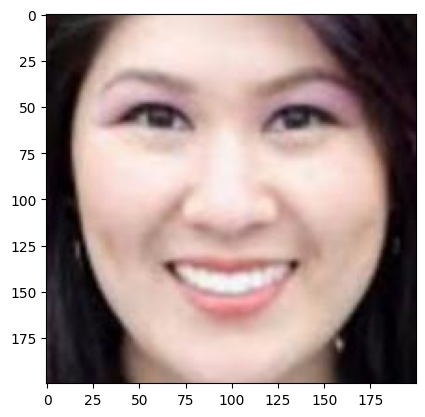

In [10]:
# read an img
img = cv2.imread("utils/combined_faces/30_2.jpg")
# show img

from matplotlib import pyplot as plt

img_2_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_2_show)
plt.show()

In [12]:
train_df[train_df['filename']=='30_2.jpg']

,sec1,sec2,sec3,sec4,sec5,sec6,sec7,sec8,sec9,sec10,...,sec6474,sec6475,sec6476,sec6477,sec6478,sec6479,sec6480,age,target,filename
4540,0.059229,0.051935,0.081051,0.022174,0.017352,0.102594,0.075983,0.060663,0.01433,0.016575,...,0.02425,0.162662,0.18542,0.009705,0.004053,0.02375,0.063688,30.0,2.0,30_2.jpg


In [13]:
feature_from_csv = np.array(train_df[train_df['filename']=='30_2.jpg'].values.tolist()[0][:-3])
print(feature_from_csv.shape)
feature_from_csv

(6480,)


array([0.05922857, 0.05193526, 0.08105137, ..., 0.00405272, 0.02375005,
       0.06368788])

In [14]:
N = 6480
orientations = 5
pixels_per_cell = (16, 16)
cells_per_block = (4, 4)

# Converting the coloured image to a grayscale image.
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Extracting the HOG features from the grayscale image.
fd = hog(img_gray, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, block_norm='L2', visualize=False, transform_sqrt=True)
fd = np.array(fd)
print(fd.shape)
print(fd)

(6480,)
[0.05922857 0.05193526 0.08105137 ... 0.00405272 0.02375005 0.06368788]


In [15]:
caclulated_euclidean_distances = np.sqrt(np.sum((feature_from_csv - fd)**2))
caclulated_euclidean_distances

4.374446516439701e-15

In [16]:
# # Example of making predictions
# from math import sqrt

# # calculate the Euclidean distance between two vectors
# def euclidean_distance(row1, row2):
# 	distance = 0.0
# 	for i in range(len(row1)-1):
# 		distance += (row1[i] - row2[i])**2
# 	return sqrt(distance)

# # Locate the most similar neighbors
# def get_neighbors(train, test_row, num_neighbors):
# 	distances = list()
# 	for train_row in train:
# 		dist = euclidean_distance(test_row, train_row)
# 		distances.append((train_row, dist))
# 	distances.sort(key=lambda tup: tup[1])
# 	neighbors = list()
# 	for i in range(num_neighbors):
# 		neighbors.append(distances[i][0])
# 	return neighbors

# # Make a classification prediction with neighbors
# def predict_classification(train, test_row, num_neighbors):
# 	neighbors = get_neighbors(train, test_row, num_neighbors)
# 	output_values = [row[-1] for row in neighbors]
# 	prediction = max(set(output_values), key=output_values.count)
# 	return prediction

# # Test distance function
# dataset = [[2.7810836,2.550537003,0],
# 	[1.465489372,2.362125076,0],
# 	[3.396561688,4.400293529,0],
# 	[1.38807019,1.850220317,0],
# 	[3.06407232,3.005305973,0],
# 	[7.627531214,2.759262235,1],
# 	[5.332441248,2.088626775,1],
# 	[6.922596716,1.77106367,1],
# 	[8.675418651,-0.242068655,1],
# 	[7.673756466,3.508563011,1]]
# prediction = predict_classification(dataset, dataset[0], 3)
# print('Expected %d, Got %d.' % (dataset[0][-1], prediction))

In [17]:
train_df

,sec1,sec2,sec3,sec4,sec5,sec6,sec7,sec8,sec9,sec10,...,sec6474,sec6475,sec6476,sec6477,sec6478,sec6479,sec6480,age,target,filename
0,0.423507,0.018889,0.012394,0.009579,0.100163,0.150292,0.023945,0.001845,0.005284,0.026846,...,0.411198,0.240025,0.005183,0.005829,0.163891,0.032640,0.002412,38.0,2.0,38_136.jpg
1,0.002415,0.000244,0.006556,0.000244,0.000000,0.015198,0.001465,0.003106,0.000976,0.000000,...,0.005675,0.003905,0.019317,0.022447,0.007020,0.002762,0.000298,1.0,1.0,1_195.jpg
2,0.033558,0.056283,0.017254,0.000154,0.002615,0.013257,0.044397,0.004264,0.000088,0.000140,...,0.482713,0.142037,0.013227,0.005120,0.005032,0.006044,0.005839,21.0,2.0,21_469.jpg
3,0.085965,0.032220,0.071718,0.103594,0.138163,0.145130,0.074026,0.094690,0.117337,0.104484,...,0.121752,0.009510,0.127481,0.071217,0.124961,0.021395,0.011218,26.0,2.0,26_1649.jpg
4,0.014213,0.016784,0.010332,0.010480,0.012398,0.150060,0.043606,0.028280,0.056114,0.173562,...,0.008028,0.014250,0.019762,0.017716,0.009774,0.018017,0.030261,54.0,3.0,54_419.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23435,0.038818,0.021195,0.027264,0.057173,0.164173,0.312733,0.041423,0.001972,0.002578,0.003018,...,0.005133,0.014200,0.225668,0.003702,0.016907,0.060721,0.106805,5.0,1.0,5_358.jpg
23436,0.132144,0.042062,0.021850,0.012542,0.053584,0.090470,0.029809,0.056685,0.081959,0.063967,...,0.010052,0.045535,0.030437,0.001922,0.000168,0.001564,0.001286,10.0,1.0,10_244.jpg
23437,0.373522,0.071214,0.043117,0.013120,0.060837,0.088353,0.094150,0.017710,0.006755,0.009003,...,0.025088,0.127610,0.296769,0.009512,0.005150,0.009723,0.118209,8.0,1.0,8_66.jpg
23438,0.089685,0.029039,0.017325,0.036333,0.043359,0.050021,0.004977,0.011238,0.033121,0.034815,...,0.256545,0.341163,0.115089,0.040936,0.027125,0.396675,0.257266,33.0,2.0,33_117.jpg


In [ ]:
train_sampled_df = train_sampled_df.values.tolist()

In [52]:
# Example of making predictions
from math import sqrt

# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)

# Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
	distances = list()
	for train_row in train:
		dist = euclidean_distance(train_row[:-3], test_row)
		distances.append((train_row, dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i])
	return neighbors

# Make a classification prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
	neighbors = get_neighbors(train, test_row, num_neighbors)
	output_values = [row[0][-2] for row in neighbors]
	prediction = max(set(output_values), key=output_values.count)
	neighbors = [(row[0][-3], row[0][-2], row[0][-1], row[1]) for row in neighbors]
	return prediction, neighbors


prediction, neighbors = predict_classification(train_sampled_df, fd, 3)

In [53]:
prediction

2.0

In [54]:
neighbors

[(60.0, 3.0, '60_8.jpg', 5.004045439198263),
 (24.0, 2.0, '24_534.jpg', 5.195379581544892),
 (36.0, 2.0, '36_95.jpg', 5.291535524323555)]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

# Load the HOG vectors from the separate CSV files
less_20 = pd.read_csv('less_20.csv', header=None)
less_20_label = '<20'

20_45 = pd.read_csv('20_45.csv', header=None)
20_45_label = '20-45'

more_45 = pd.read_csv('more_45.csv', header=None)
more_45_label = '>45'

# Convert the dataframes to numpy arrays
less_20_X = less_20.values
20_45_X = 20_45.values
more_45_X = more_45.values

# Calculate distances between the input vector and the vectors in each file
def calculate_distances(input_vector, X):
    distances = np.linalg.norm(X - input_vector, axis=1)
    return distances

# Load the input vector that you want to classify
# Replace this with the actual input vector that you have
input_vector = np.array([...])  # Replace this with the actual input vector

# Calculate distances between the input vector and the vectors in each file
less_20_distances = calculate_distances(input_vector, less_20_X)
20_45_distances = calculate_distances(input_vector, 20_45_X)
more_45_distances = calculate_distances(input_vector, more_45_X)

# Find the index of the nearest vector for each file
less_20_nearest_index = np.argmin(less_20_distances)
20_45_nearest_index = np.argmin(20_45_distances)
more_45_nearest_index = np.argmin(more_45_distances)

# Get the label of the nearest vector for each file
less_20_nearest_label = less_20_label
20_45_nearest_label = 20_45_label
more_45_nearest_label = more_45_label

print('Input vector is classified as:')
print('<20:', less_20_nearest_label)
print('20-45:', 20_45_nearest_label)
print('>45:', more_45_nearest_label)


In [ ]:
import tensorflow as tf

tf.__version__

d:\anaconda3\envs\csdlpt\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\anaconda3\envs\csdlpt\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\anaconda3\envs\csdlpt\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\anaconda3\envs\csdlpt\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

'1.14.0'

In [ ]:
import imutils
import numpy as np
import cv2

In [ ]:
image_file = "img_via.jpg"

In [ ]:
print("[INFO] loading model...")
prototxt = 'utils/deploy.prototxt'
model = 'utils/res10_300x300_ssd_iter_140000.caffemodel'
face_detect_net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] loading model...


In [ ]:
img = cv2.imread(image_file)

image = img.copy()

(h_img, w_img) = image.shape[:2]
blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), (104.0, 177.0, 123.0))
face_detect_net.setInput(blob)
detections = face_detect_net.forward()

rects = []
i = 0

global LIST_FACES
LIST_FACES = []

global LIST_EMB_FACES
LIST_EMB_FACES = {}

for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the prediction
        confidence = detections[0, 0, i, 2]
        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence threshold
        if confidence > 0.2:
            # compute the (x, y)-coordinates of the bounding box for the object
            # box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            # (startX, startY, endX, endY) = box.astype("int")
            # print((startX, startY, endX, endY))
            # # draw the bounding box of the face along with the associated probability
            # text = "{:.2f}%".format(confidence * 100)
            # y = startY - 10 if startY - 10 > 10 else startY + 10
            # cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            # cv2.putText(image, text, (startX, y),
            # cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)


            box = detections[0, 0, i, 3:7] * np.array([w_img, h_img, w_img, h_img])
            (startX, startY, endX, endY) = box.astype("int")
            print((startX, startY, endX, endY))
            x = startX
            y = startY
            w = endX - startX
            h = endY - startY
            rects.append((x, y, w, h))
            print((x, y, w, h))
            print()
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, "#{} - {:.2f}%".format(i + 1, confidence * 100), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            # cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            face_image = image[y:y+h, x:x+w]
            face_image = cv2.resize(face_image, (200, 200))
            LIST_FACES.append(face_image)

(579, 220, 730, 401)
(579, 220, 151, 181)

(653, 462, 802, 664)
(653, 462, 149, 202)

(916, 109, 1092, 346)
(916, 109, 176, 237)

(406, 340, 589, 567)
(406, 340, 183, 227)

(804, 426, 975, 651)
(804, 426, 171, 225)



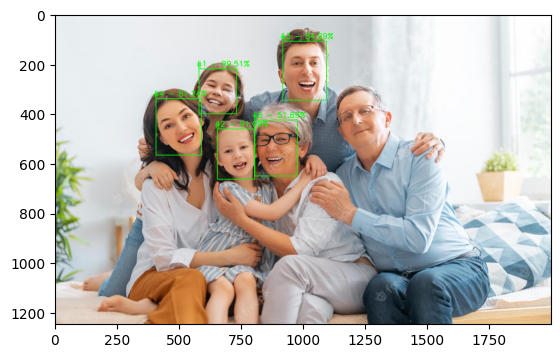

In [ ]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

#Show the image with matplotlib
plt.imshow(image)
plt.show()